In [1]:
import numpy as np
import os.path
import yaml
import pickle

from utils import *
from Environment import Environment
from Model import QNetwork

# set np seed
np.random.seed(0)

import os
file_path = "config.yaml"

# Load the YAML config file
with open(file_path, "r") as file:
    config_file = yaml.safe_load(file)

# CONFIGS
config = config_file["test"]

paths_config = config["paths"]

GRID_MAP_FILE = paths_config["map_file"]
HEURISTIC_MAP_FILE = paths_config["heur_file"]

DIR = config["root"] + paths_config["results"]
log_path = DIR + "log/"

if not os.path.exists(log_path):
    os.makedirs(log_path)

logger = Logger(log_path+"test.txt")

/localhome/esa95/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Warehouse map

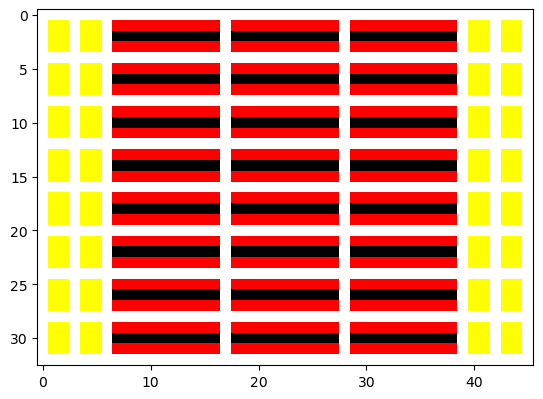

In [2]:
ROWS = 8
COLS = 3

NUM_GOALS = 5000

num_agents = config["environment"]["NUM_AGENTS"]

num_of_agents = list(range(50, 101, 10))
for num_agents in num_of_agents:
    warehouse, start_locs, goal_locs = generate_warehouse(ROWS, COLS, num_agents=num_agents, num_goals=NUM_GOALS, seed=0)
    start_locs = [(loc[0]+1, loc[1]+1) for loc in start_locs]

    if not os.path.exists("maps/warehouse_2/"):
        os.makedirs("maps/warehouse_2/")
    with open(f"maps/warehouse_2/start_locs_{num_agents}N.pkl", "wb") as f:
        pickle.dump(start_locs, f)

    goal_locs = [[(loc[0]+1, loc[1]+1) for loc in goal] for goal in goal_locs]
    with open(f"maps/warehouse_2/goal_locs_{num_agents}N.pkl", "wb") as f:
        pickle.dump(goal_locs, f)

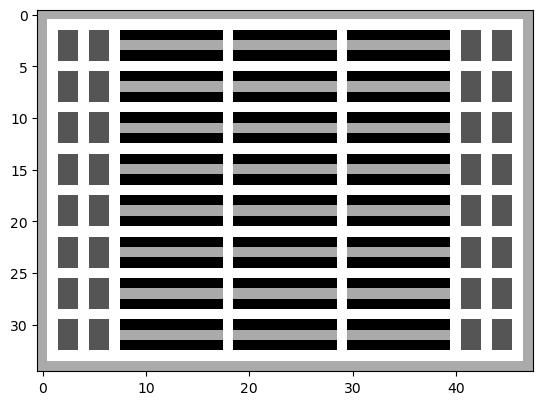

In [9]:
warehouse = np.pad(warehouse, 1, 'constant', constant_values=1)

station_locs = np.where(warehouse == 2)
station_locs = np.array(list(zip(station_locs[0], station_locs[1])))
np.save("maps/warehouse_2/start_options.npy", station_locs)

shelves_locs = np.where(warehouse == 3)
shelves_locs = np.array(list(zip(shelves_locs[0], shelves_locs[1])))
np.save("maps/warehouse_2/goal_options.npy", shelves_locs)

plt.imshow(warehouse, cmap='gray_r')

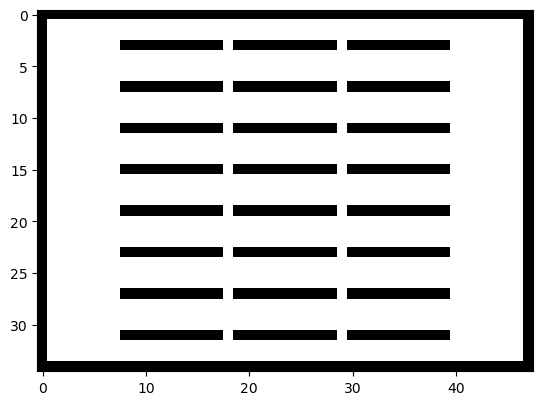

In [10]:
grid_map = np.where((warehouse == 2) | (warehouse == 3), 0, warehouse)

plt.imshow(grid_map, cmap='gray_r')
np.save("maps/warehouse_2/grid_map.npy", grid_map)

Environment.__init__: loading heuristic map from file


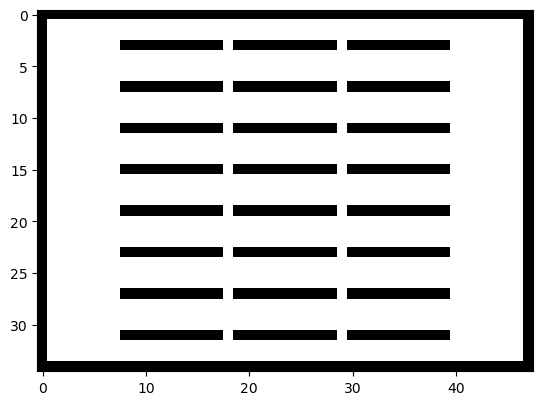

In [2]:
env_config = config["environment"]

env = Environment(env_config, logger=logger, grid_map_file=GRID_MAP_FILE, start_loc_options=paths_config['start_options'],
                  goal_loc_options=paths_config['goal_options'], heuristic_map_file=HEURISTIC_MAP_FILE, start_loc_file=paths_config['start_locs'], goal_loc_file=paths_config['goal_locs'])

plt.imshow(env.grid_map, cmap='binary')

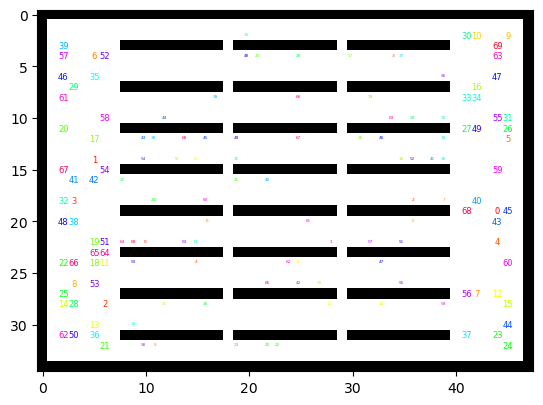

In [3]:
env.show_current_state()

In [4]:
import random
import time

np.random.seed(0)

for i in range(5000):
    start_time = time.time()
    
    while time.time() - start_time < 60:
        prio = list(range(env.num_agents))
        random.shuffle(prio)
        starts, goals = env.step(prio)
        if starts is not None:
            print(prio)
            break

    print(i)
    if starts is None:
        break

[28, 61, 67, 42, 29, 40, 36, 56, 52, 31, 43, 3, 26, 54, 11, 24, 7, 10, 15, 23, 66, 12, 2, 0, 17, 25, 1, 63, 47, 46, 14, 44, 55, 20, 27, 57, 41, 35, 64, 21, 4, 69, 59, 9, 38, 45, 34, 16, 39, 6, 48, 60, 18, 8, 32, 13, 37, 22, 30, 19, 68, 50, 58, 51, 62, 65, 33, 5, 53, 49]
0
[23, 49, 26, 31, 1, 22, 29, 58, 0, 44, 19, 33, 41, 56, 53, 3, 10, 60, 43, 47, 14, 48, 50, 61, 46, 21, 6, 27, 7, 32, 40, 17, 25, 55, 63, 9, 8, 68, 4, 30, 16, 39, 2, 45, 12, 11, 54, 64, 36, 20, 24, 57, 5, 28, 18, 69, 35, 66, 51, 67, 34, 59, 52, 42, 15, 37, 38, 13, 62, 65]
1
[63, 24, 17, 69, 52, 44, 43, 33, 49, 66, 50, 10, 26, 0, 21, 20, 29, 15, 46, 8, 37, 47, 31, 41, 32, 65, 39, 56, 60, 57, 42, 22, 19, 35, 14, 4, 16, 6, 27, 34, 48, 3, 13, 30, 51, 45, 11, 59, 62, 58, 2, 55, 23, 64, 25, 61, 36, 53, 38, 67, 40, 68, 1, 9, 5, 28, 18, 12, 7, 54]
2
[16, 6, 50, 38, 28, 3, 9, 53, 31, 41, 59, 54, 11, 4, 69, 27, 62, 42, 25, 23, 36, 1, 13, 66, 64, 61, 33, 14, 20, 68, 7, 10, 56, 12, 60, 57, 26, 24, 63, 51, 46, 40, 37, 55, 43, 18, 67

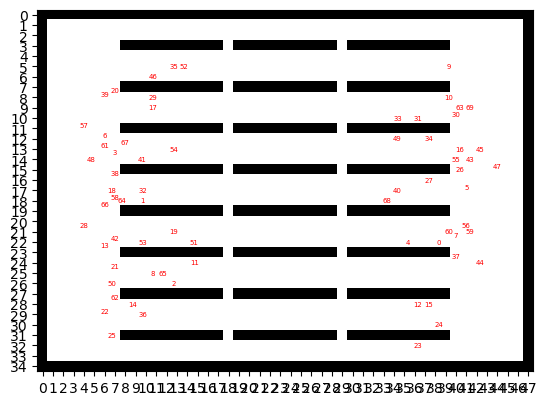

In [9]:
from matplotlib.animation import FuncAnimation

def update_plot(frame, grid, paths):
    plt.cla()
    plt.imshow(grid, cmap='binary')

    for i, path in enumerate(paths):
        if frame < len(path):
            x, y = path[frame]
            plt.text(y, x, str(i), ha='center', va='center', fontsize=5, color='red')

    # plt.gca().invert_yaxis()
    plt.xticks(range(len(grid[0])))
    plt.yticks(range(len(grid)))

paths = [[(x, y) for x, y, t in path ]for path in env.paths]

smoothness = 3
new_paths = []
for path in paths:
    new_path = []
    for i in range(len(path)-1):
        new_path.append(path[i])
        for j in range(1, smoothness):
            dir_y = path[i+1][0] - path[i][0]
            dir_x = path[i+1][1] - path[i][1]
            new_c = (path[i][0]+(dir_y/smoothness*j), path[i][1]+(dir_x/smoothness*j))
            new_path.append(new_c)
    new_paths.append(new_path)

fig = plt.figure()
ani = FuncAnimation(fig, update_plot, frames=max(len(path)
                    for path in new_paths), fargs=(env.grid_map, new_paths), interval=200)
ani.save('paths.gif', writer='imagemagick')
plt.show()

# Random map

In [9]:
# def generate_random_map(rows, cols, num_agents, num_goals, seed=None):
    # np.random.seed(seed)

from generate_map import generate_map

rows, cols, num_goals = 20, 20, 5000
# different obstacle densities
obs_densities = [20, 40, 60]
for obstacle_density in obs_densities:
    if not os.path.exists(f"maps/random_{obstacle_density}/"):
        os.makedirs(f"maps/random_{obstacle_density}/")

    grid_map = generate_map(rows, cols, obstacle_density/100)
    # grid_map.npy
    np.save(f"maps/random_{obstacle_density}/grid_map.npy", grid_map)
    
    # start_options.npy
    start_options = np.where(grid_map == 0)
    start_options = np.array(list(zip(start_options[0], start_options[1])))
    np.save(f"maps/random_{obstacle_density}/start_options.npy", start_options)

    # goal_options.npy
    goal_options = np.where(grid_map == 0)
    goal_options = np.array(list(zip(goal_options[0], goal_options[1])))
    np.save(f"maps/random_{obstacle_density}/goal_options.npy", start_options)

    # different number of agents
    num_agents_list = [10, 20, 30, 40, 50]
    for num_agents in num_agents_list:
        # start_locs_XN.pkl/
        np.random.shuffle(start_options)
        np.random.shuffle(goal_options)

        start_locs = start_options[:num_agents]
        start_locs = [(loc[0], loc[1]) for loc in start_locs]
        with open(f"maps/random_{obstacle_density}/start_locs_{num_agents}N.pkl", "wb") as f:
            pickle.dump(start_locs, f)

        # goal_locs_XN.pkl
        rng = np.random.default_rng()
        rng.shuffle(goal_options)
        goal_locs = np.array([[i] for i in goal_options[:num_agents].copy()])
        for i in range(num_goals):
            rng.shuffle(goal_options)
            new_goals = goal_options[:num_agents].copy()
            goal_locs = np.concatenate((goal_locs, new_goals[:, None, :]), axis=1)

        goal_locs = [[(loc[0], loc[1]) for loc in goal] for goal in goal_locs]

        with open(f"maps/random_{obstacle_density}/goal_locs_{num_agents}N.pkl", "wb") as f:
            pickle.dump(goal_locs, f)

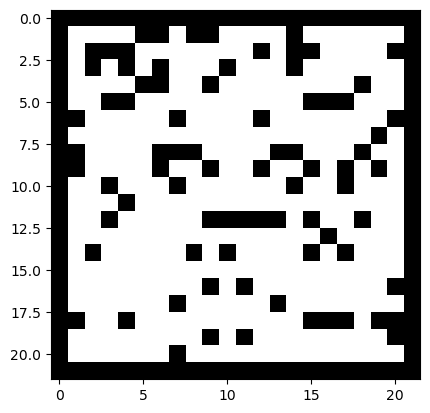

In [15]:
grid_map = np.load("maps/random_20/grid_map.npy")
plt.imshow(grid_map, cmap='binary')

In [ ]:
# CREATE TESTING SET
# save start, goal locations

filename = f'./testing_set/test_set_{num_agents}_1.pickle'

if not os.path.exists(filename):
    num_goals = 1000
    grid_map = env.grid_map

    empty_cells = np.where(grid_map == 0)
    empty_cells = np.array(list(zip(empty_cells[0], empty_cells[1])))

    rng = np.random.default_rng()
    rng.shuffle(empty_cells)

    start_locs = empty_cells[:num_agents]

    rng.shuffle(empty_cells)
    goal_locs = np.array([[i] for i in empty_cells[:num_agents].copy()])
    for i in range(num_goals):
        rng.shuffle(empty_cells)
        new_shelves = empty_cells[:num_agents].copy()
        goal_locs = np.concatenate((goal_locs, new_shelves[:, None, :]), axis=1)

    start_locs = [(loc[0], loc[1]) for loc in start_locs]
    goal_locs = [[(loc[0], loc[1]) for loc in goal] for goal in goal_locs]

    test_set = {'start_locations': start_locs, 'goal_locations': goal_locs}

    with open(filename, 'wb') as handle:
        pickle.dump(test_set, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [5]:
env.reset(num_agents=num_agents)
filename = f'./testing_set/test_set_{num_agents}_1.pickle'

with open(filename, 'rb') as handle:
    test_set = pickle.load(handle)

start_locations = test_set['start_locations']
goal_locations = test_set['goal_locations']

idx = 0

env.starts = start_locations.copy()
env.optimal_starts = start_locations.copy()
env.goals = goal_locations.copy()

# env.show_current_state()

# Overfit test

(0, 1) [-0.104  0.059] [0.459 0.541]
(0, 2) [-0.655 -0.676] [0.505 0.495]
(0, 3) [-0.243 -0.32 ] [0.519 0.481]
(1, 2) [ 0.038 -0.06 ] [0.524 0.476]
(1, 3) [ 0.133 -0.125] [0.564 0.436]
(2, 3) [-0.552 -0.676] [0.531 0.469]
priorities [1, 0, 2, 3]
Global Reward: -7


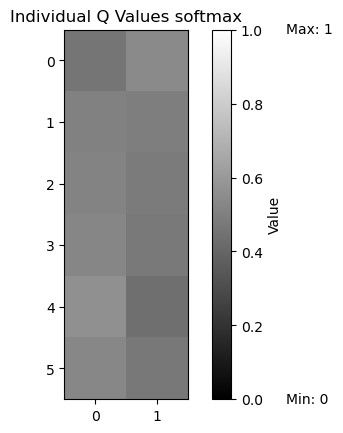

In [7]:
# OVERFIT TEST
env.reset(num_agents=4)

FIXED_START = [(11, 5), (11, 6), (11, 7), (13, 5)]
FIXED_GOALS = [[(12, 3), (10, 2), (1, 2)],
               [(11, 7), (13, 8), (1, 2)],
               [(12, 5), (14, 6), (1, 2)],
               [(11, 6), (9, 7), (1, 2)]]

# FORCE START AND GOAL LOCATION
new_start, new_goals = copy.deepcopy(FIXED_START), copy.deepcopy(FIXED_GOALS)
env.starts, env.goals = new_start, new_goals

# get observation FOVs
obs_fovs = env.get_obs_fov(new_start, new_goals)
obs_fovs = torch.where(torch.isinf(obs_fovs), torch.tensor(-1), obs_fovs)

# form list of close agents
close_pairs = env.get_close_pairs()

# feed to model to get q_val
pair_enc, q_vals = q_net(obs_fovs.unsqueeze(0), [close_pairs])

plt.imshow(F.softmax(q_vals[0], dim=1).detach().numpy(), vmin=0, vmax=1, cmap='gray')
# print Q values for each pair
cbar = plt.colorbar()
cbar.set_label('Value')  # Label for the colorbar
# Annotate the colorbar with min and max values
cbar.ax.text(4, 0, f"Min: 0", ha='left', va='center', fontsize=10, transform=cbar.ax.transAxes)
cbar.ax.text(4, 1, f"Max: 1", ha='left', va='center', fontsize=10, transform=cbar.ax.transAxes)
plt.title("Individual Q Values softmax")
plt.savefig("indiv_q_vals_alt.png")

for p, q in zip(close_pairs, np.array([np.round(i.detach().numpy().squeeze(), 3) for i in q_vals][0])):
    print(p, q, np.round(F.softmax(torch.tensor(q), dim=0).detach().numpy().squeeze(), 3))

priorities, partial_prio, pred_value = sample_priorities(env, logger, close_pairs, q_vals[0], policy='greedy')
if priorities is None:
    priorities, partial_prio, pred_value = sample_priorities(env, logger, close_pairs, q_vals[0], policy='stochastic')

tries = 0
while tries < 10:
    new_start, new_goals = env.step(priorities)
    if new_start is not None:
        break
    priorities, partial_prio, pred_value = sample_priorities(env, close_pairs, q_vals[0], policy='stochastic')
    tries += 1

print("priorities", priorities)

# global reward from sum of delays
global_reward = sum([-x for x in env.get_delays()])

print("Global Reward:", global_reward)

(1, 0) [ 0.058 -0.05 ] [0.527 0.473]
(2, 0) [-0.62  -0.512] [0.473 0.527]
(3, 0) [-0.327 -0.221] [0.474 0.526]
(2, 1) [-0.189 -0.063] [0.469 0.531]
(3, 1) [-0.266 -0.005] [0.435 0.565]
(3, 2) [-0.782 -0.599] [0.454 0.546]
priorities [1, 0, 2, 3]
Global Reward: -7


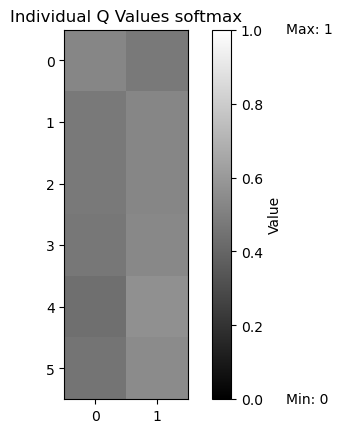

In [8]:
# OVERFIT TEST
env.reset(num_agents=4)

FIXED_START = [(11, 5), (11, 6), (11, 7), (13, 5)]
FIXED_GOALS = [[(12, 3), (10, 2), (1, 2)],
               [(11, 7), (13, 8), (1, 2)],
               [(12, 5), (14, 6), (1, 2)],
               [(11, 6), (9, 7), (1, 2)]]

# FORCE START AND GOAL LOCATION
new_start, new_goals = copy.deepcopy(FIXED_START), copy.deepcopy(FIXED_GOALS)
env.starts, env.goals = new_start, new_goals

# get observation FOVs
obs_fovs = env.get_obs_fov(new_start, new_goals)
obs_fovs = torch.where(torch.isinf(obs_fovs), torch.tensor(-1), obs_fovs)

# form list of close agents
close_pairs = env.get_close_pairs()
close_pairs = [(x[1], x[0]) for x in close_pairs]

# feed to model to get q_val
pair_enc, q_vals = q_net(obs_fovs.unsqueeze(0), [close_pairs])

plt.imshow(F.softmax(q_vals[0], dim=1).detach().numpy(), vmin=0, vmax=1, cmap='gray')
# print Q values for each pair
cbar = plt.colorbar()
cbar.set_label('Value')  # Label for the colorbar
# Annotate the colorbar with min and max values
cbar.ax.text(4, 0, f"Min: 0", ha='left', va='center', fontsize=10, transform=cbar.ax.transAxes)
cbar.ax.text(4, 1, f"Max: 1", ha='left', va='center', fontsize=10, transform=cbar.ax.transAxes)
plt.title("Individual Q Values softmax")
plt.savefig("indiv_q_vals_alt.png")

for p, q in zip(close_pairs, np.array([np.round(i.detach().numpy().squeeze(), 3) for i in q_vals][0])):
    print(p, q, np.round(F.softmax(torch.tensor(q), dim=0).detach().numpy().squeeze(), 3))

priorities, partial_prio, pred_value = sample_priorities(env, logger, close_pairs, q_vals[0], policy='greedy')
if priorities is None:
    priorities, partial_prio, pred_value = sample_priorities(env, logger, close_pairs, q_vals[0], policy='stochastic')

tries = 0
while tries < 10:
    new_start, new_goals = env.step(priorities)
    if new_start is not None:
        break
    priorities, partial_prio, pred_value = sample_priorities(env, logger, close_pairs, q_vals[0], policy='stochastic')
    tries += 1

print("priorities", priorities)

# global reward from sum of delays
global_reward = sum([-x for x in env.get_delays()])

print("Global Reward:", global_reward)